# 0. Importing modules and handy functions

In [96]:
# Standard modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Modeling modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [112]:
# function to modify graph parameters
def cute_graph(title=None, xlabel = None, ylabel = None, xticklabels = None):
    # Handy function that changes several parameters of the plot 
    # to make it look a bit better. 
    
    sns.despine(bottom = True, left = True)
    ax.bar_label(ax.containers[0], fmt='%.3g')
    plt.tick_params(labelleft=False, left=False)
    
    if title != None:
        if len(title) == 2:
            plt.title(title[0],fontsize=title[1])
        else:
            plt.title(title)
            
    if xlabel != None:
        if len(xlabel) == 2:
            plt.xlabel(xlabel[0],fontsize=xlabel[1])
        else:
            plt.xlabel(xlabel)
                   
    if ylabel != None:
        if len(ylabel) == 2:
            plt.ylabel(ylabel[0],fontsize=ylabel[1])
        else:
            plt.ylabel(ylabel)
    
    if xticklabels != None:
        ax.set(xticklabels=xticklabels)
        
    ax.xaxis.set_ticks_position('none') 
    return

# 1. Reading data

In [2]:
# Reading the rides data
rides = pd.read_csv('../data/measurements.csv',decimal=',')
rides.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


# 2. Cleaning data

In [3]:
# Checking that each column is correctly classified
rides.dtypes

distance         float64
consume          float64
speed              int64
temp_inside      float64
temp_outside       int64
specials          object
gas_type          object
AC                 int64
rain               int64
sun                int64
refill liters    float64
refill gas        object
dtype: object

## 2.1 Cleaning NaNs

In [4]:
# Let's deal with "specials" column NaNs. These are actually rides where the is nothing special, so I'll 
# name that category as "normal"
rides['specials'] = rides['specials'].fillna('normal')

In [5]:
rides = rides.copy()
# We still have more NaNs to treat frm refill liters and refill gas. The ones on "refill gas"
# are equal to no refilling, so I'll switch then with the category "No", and hence the "refill liters"
# should be zero.
rides['refill liters'] = rides['refill liters'].fillna(0)
rides['refill gas'] = rides['refill gas'].fillna('No')

In [6]:
# We do also have 12 NaNs in some rides where the driver did not note the temperature inside the car. 
rides[rides['temp_inside'].isna()]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
93,12.4,4.7,43,NaN,10,normal,SP98,0,0,0,0.0,No
95,11.8,5.3,52,NaN,11,normal,SP98,0,0,0,0.0,No
97,15.7,5.3,33,NaN,9,normal,SP98,0,0,0,0.0,No
98,12.9,5.7,35,NaN,9,normal,SP98,0,0,0,0.0,No
99,6.4,4.4,37,NaN,10,normal,SP98,0,0,0,0.0,No
100,5.3,4.1,34,NaN,9,normal,SP98,0,0,0,0.0,No
102,18.8,5.0,62,NaN,9,rain,SP98,0,1,0,0.0,No
201,22.2,3.8,42,NaN,15,normal,SP98,0,0,0,0.0,No
203,12.6,4.1,33,NaN,17,normal,SP98,0,0,0,0.0,No
261,24.5,3.9,50,NaN,15,sun,E10,0,0,1,0.0,No


In [7]:
# 12 might no seem huge, but when we notice that our database only have 388 rows, then it's a problem. Instead
# of getting rid of these columns, we will use the mean temp_inside as an aproximation.
rides['temp_inside'] = rides['temp_inside'].fillna(round(rides['temp_inside'].mean(),1))

## 2.2 Dealing with categories

We can see that the column "specials" is the combination of the columns AC, rain and sun. But if we have a closer look at the unique values of specials, we can see that we have no column for snow. We can't miss that column because even if it did not rain and it was not very sunny, we still do not know if it snowed or not. So we need that column and I'll create it.

In [8]:
rides['specials'].unique()

array(['normal', 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun',
       'ac rain'], dtype=object)

In [9]:
# Creating a column equal to 1 if 'specials' contains the word snow
rides['snow'] = rides['specials'].apply(lambda x: np.where('snow' in x,1,0))

# Rearranging the order of columns and dropping the (useless now) 'specials' column
rides = rides[['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC', 'rain',
         'sun', 'snow', 'refill liters','refill gas']]

In [10]:
display(rides.head())
# We can also see we have no nans left
rides.isna().sum().sum()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,snow,refill liters,refill gas
0,28.0,5.0,26,21.5,12,E10,0,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,E10,0,0,0,0,0.0,No
2,11.2,5.5,38,21.5,15,E10,0,0,0,0,0.0,No
3,12.9,3.9,36,21.5,14,E10,0,0,0,0,0.0,No
4,18.5,4.5,46,21.5,15,E10,0,0,0,0,0.0,No


0

In [36]:
# We're interested in the features that affect the consumption. That's why "refill liters" and "refill gas" 
# give us no value and should be dropped to avoid creating noise in the later model.
rides = rides.drop(['refill liters','refill gas'],axis=1)

In [126]:
#Saving the clean csv
rides.to_csv('../data/clean_rides.csv',index=False)

# 3. Exploratory data analysis

In [37]:
# Checking general parameters of our data
rides.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,388.0,19.652835,22.667837,1.3,11.80,14.6,19.0,216.1
consume,388.0,4.912371,1.033172,3.3,4.30,4.7,5.3,12.2
speed,388.0,41.927835,13.598524,14.0,32.75,40.5,50.0,90.0
temp_inside,388.0,21.928608,0.994679,19.0,21.50,22.0,22.5,25.5
temp_outside,388.0,11.358247,6.991542,-5.0,7.00,10.0,16.0,31.0
AC,388.0,0.077320,0.267443,0.0,0.00,0.0,0.0,1.0
rain,388.0,0.123711,0.329677,0.0,0.00,0.0,0.0,1.0
sun,388.0,0.082474,0.275441,0.0,0.00,0.0,0.0,1.0
snow,388.0,0.010309,0.101140,0.0,0.00,0.0,0.0,1.0


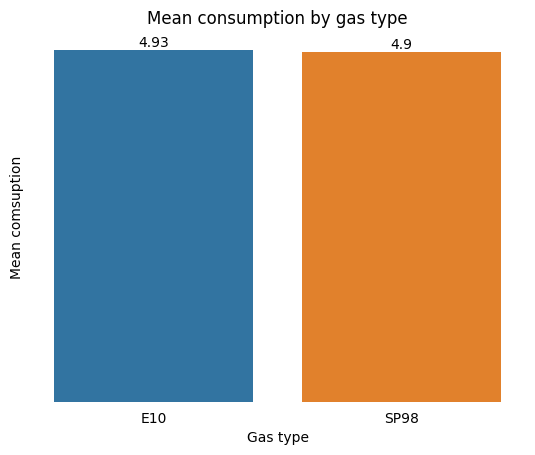

In [106]:
# Let's start by looking at the mean consumption for each type of combustible
ax = sns.barplot(x='gas_type',y='consume',data=rides,errorbar = None)
plt.title('Mean consumption by gas type')
plt.xlabel('Gas type')
plt.ylabel('Mean comsuption')
cute_graph()
plt.show()

At first glimpse, it seems that both fuels consume almost the same. But is this true? Let's see if we have the same conditions for both kind of rides (maybe one was used more in winter, leading to a higher consumption).

In [39]:
print('E10 gast type rides have these proportion of conditions on its trips:')
print(rides[rides.gas_type=='E10'][['rain','sun','snow']].sum())
print('\nSP98 gast type rides have these proportion of conditions on its trips:')
print(rides[rides.gas_type=='SP98'][['rain','sun','snow']].sum())

E10 gast type rides have these proportion of conditions on its trips:
rain    16
sun     12
snow     1
dtype: int64

SP98 gast type rides have these proportion of conditions on its trips:
rain    32
sun     20
snow     3
dtype: int64


In [40]:
# We can look at this in an easier way by computing the percentages:

print('E10 gast type rides have these proportion of conditions on its trips:')
print(rides[rides.gas_type=='E10'][['rain','sun','snow']].sum()/rides[rides.gas_type=='E10'][['rain','sun','snow']].sum().sum()*100)
print('\nSP98 gast type rides have these proportion of conditions on its trips:')
print(rides[rides.gas_type=='SP98'][['rain','sun','snow']].sum()/rides[rides.gas_type=='SP98'][['rain','sun','snow']].sum().sum()*100)

E10 gast type rides have these proportion of conditions on its trips:
rain    55.172414
sun     41.379310
snow     3.448276
dtype: float64

SP98 gast type rides have these proportion of conditions on its trips:
rain    58.181818
sun     36.363636
snow     5.454545
dtype: float64


In [41]:
print('E10 gast type rides have a mean temp_inside,temp_outside and speed of:')
print(rides[rides.gas_type=='E10'][['temp_inside','temp_outside','speed']].mean())
print('\nSP98 gast type rides have a mean temp_inside,temp_outside and speed of:')
print(rides[rides.gas_type=='SP98'][['temp_inside','temp_outside','speed']].mean())

E10 gast type rides have a mean temp_inside,temp_outside and speed of:
temp_inside     21.916875
temp_outside    10.118750
speed           43.506250
dtype: float64

SP98 gast type rides have a mean temp_inside,temp_outside and speed of:
temp_inside     21.936842
temp_outside    12.228070
speed           40.820175
dtype: float64


In [42]:
# The conditions do change a bit for each kind of gas, but the difference are not huge, so we can't say if there
# will be an impact because of this. Anyways, the model will take all of this parameters into account and notice
# if they make (or not) a difference in consumption.

# 4. Modeling

## 4.1 X-Y Split

In [43]:
# Our target here is the consumption
y = rides['consume']
# And the rest are our independant variables
X = rides.drop(['consume'],axis=1)

## 4.2 Train-test split

In [44]:
# We'll split our data into test and trainning data to make sure the models is working as expected
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## 4.3 Scaling numerical values

In [45]:
# Since we will try different models, and some of them require scaling in order to work as expected, 
# procceed to scale the numerical data
X_train_numerical = X_train.select_dtypes(np.number)
X_test_numerical = X_test.select_dtypes(np.number)

In [46]:
# Creating the transformer
transformer = MinMaxScaler().fit(X_train_numerical)

# Using it for the train data
X_normalized = transformer.transform(X_train_numerical)
X_normalized = pd.DataFrame(X_normalized, columns=X_train_numerical.columns)

# Using it for the test data
X_normalized_test = transformer.transform(X_test_numerical)
X_normalized_test = pd.DataFrame(X_normalized_test, columns=X_test_numerical.columns)

## 4.4 One-hot encoding categorical values

In [47]:
# Selecting categorical columns
X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

In [49]:
# Creating the encoder
encoder = OneHotEncoder(handle_unknown='error',drop='first').fit(X_train_cat)

# Encoding train data
encoded = encoder.transform(X_train_cat).toarray()
onehot_encoded = pd.DataFrame(encoded,columns=encoder.get_feature_names_out(X_train_cat.columns))

# Enconding test data
encoded_test = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test,columns=encoder.get_feature_names_out(X_test_cat.columns))

## 4.5 Concatenating everything together

In [59]:
X_ready = pd.concat([X_normalized,onehot_encoded],axis=1)
X_ready_test = pd.concat([X_normalized_test,onehot_encoded_test],axis=1)

## 4.6 Pipeline: trying different models

In [88]:
model1 = DecisionTreeRegressor()
model2 = LinearRegression()
model3 = KNeighborsRegressor()
model4 = RandomForestRegressor()

model_pipeline = [model1, model2, model3, model4]
model_names = ['Decision Tree Regressor', 'Linear Regression', 'KNN', 'Random Forest']
scores = {}

for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_ready, y_train, cv=5))
    scores[model_name] = mean_score
print(scores)
# We can use the result to choose the best performing model

{'Decision Tree Regressor': 0.27495094029198547, 'Linear Regression': 0.10049779008791293, 'KNN': 0.13265897049592068, 'Random Forest': 0.49240252764970516}


In [97]:
# We can see the best results for a prediction come from a Random Forest Model. 
model4.fit(X_ready,y_train)
pred = model4.predict(X_ready_test)

In [98]:
mean_squared_error(pred,y_test)
# We can see that the mean error squared for our prediction is 0.43, which is not bad.

0.4320955722693036

In [99]:
# But we can't draw conclusions from this kind of model (because of its very nature). We could check
# the decision tree then, which is simpler, but feature importances can be misleading for high cardinality
# features (many unique values), such as distance. So instead, let's create a linear model instead to draw 
# realconclusions

In [101]:
model2 = LinearRegression()
model2.fit(X_ready,y_train)

LinearRegression()

In [114]:
model1 = LinearRegression()
model1.fit(X_ready,y_train)
model.feature_importances_

array([0.59107686, 0.14770159, 0.0324752 , 0.16657871, 0.01280593,
       0.03233711, 0.00537148, 0.00093079, 0.01072233])

In [104]:
# We have many columns, let's see how each one affect the consumption:
list(zip(X_ready.columns,model2.coef_))

[('distance', 0.1269714792490813),
 ('speed', -1.2988119031855176),
 ('temp_inside', -0.176840347404285),
 ('temp_outside', -1.3615309402639717),
 ('AC', 0.422555369466849),
 ('rain', 0.5464069300014099),
 ('sun', -0.23136501432595633),
 ('snow', -0.4728634577014702),
 ('gas_type_SP98', -0.11882799466966032)]

We can see that when we isolate changes in the other variables, and we only focus ouserselves in the gas type, having a gas type **SP98** corresponds to a decrease of consumption of 0.12 (which is bigger than the one we would have assume by looking at the first bar plot ~0.03). This means you're saving 2.4% in comsuption with SP98 per trip. 

We however can not talk about money without their prices (data which is missing from the database). However, checking some websites online we can see that on france the prices for E10 are 20% cheaper than SP98, meaning that even though the old SP98 might be a bit more efficient, you'll end up wasting more money. 

In addition to this, the company is concerned about the growing rates of consumption in their rides. As we can see from our model, factors that contribute up to 40 times more to this issue are:
- slow speeds
- low temperatures
- Having the air conditioner ON
- If it's raining
- If it's too sunny
- distance of the ride

We would need to study how these features have changed through time in this area, because it's probable that the increase of consumption arise from one of those factors.

**If I would've had more time I would have removed outliers (if there were any), and also create a longer tableau presentation to show the results of this analysis with graphs**